#### Import libraries


In [2]:
#Import libraries
#install.packages("Boruta")
library(data.table)       # Data manipulation
library(plyr)             # Data manipulation
library(stringr)          # String, text processing
library(vita)             # Quickly check variable importance
library(dataPreparation)  # Data preparation library
library(woeBinning)       # Decision tree–based binning for numerical and categorical variables
library(Boruta)           # Variable selection
library(varhandle)
library(stringr)
library(mlr)
library(ROCR)
library(ggplot2)

library(woeBinning)  # Bin numerical and categorical variables
library(Boruta)  # Variable selection

# Machine learning library
library(mlr) # Machine learning framework
library(caret)
library(MASS)  # LDA
library(randomForest)  # RF
library(gbm)  # Boosting library
library(xgboost)  # XGboost



##### References
In-class Kaggle Competition_Example_v3

Evaluating performance https://mlr.mlr-org.com/articles/tutorial/performance.html

Practice machine learning techniques in R with MLR package https://www.analyticsvidhya.com/blog/2016/08/practicing-machine-learning-techniques-in-r-with-mlr-package/

# Bank Data Subscription Prediction on Term Deposits

In [38]:
#Import data
trainSet = read.csv(file = "C:/Users/dwijayaweera/Documents/2nd STAT &MIL for marketing/mbd2019-in-class-competition-bank-mkt/bank_mkt_train.csv")
predictSet = read.csv(file = "C:/Users/dwijayaweera/Documents/2nd STAT &MIL for marketing/mbd2019-in-class-competition-bank-mkt/bank_mkt_test.csv")



# The predict set would be the data set which requires the prediction and it would not contain the target variable


#### Investigate Data

In [39]:
head(trainSet)

client_id,age,job,marital,education,default,housing,loan,contact,month,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,subscribe
2,29,housemaid,single,high.school,no,no,no,telephone,may,...,3,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0,0
3,39,unemployed,married,basic.9y,unknown,yes,no,telephone,jun,...,6,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,0
4,49,blue-collar,married,basic.6y,unknown,no,no,cellular,nov,...,2,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,0
5,32,self-employed,single,university.degree,no,yes,no,cellular,may,...,3,999,1,failure,-1.8,92.893,-46.2,1.299,5099.1,0
6,29,admin.,single,high.school,unknown,yes,no,cellular,jul,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,0
7,51,self-employed,married,university.degree,unknown,yes,no,telephone,jun,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1,0


In [40]:
str(trainSet)

'data.frame':	7000 obs. of  21 variables:
 $ client_id     : int  2 3 4 5 6 7 8 9 14 15 ...
 $ age           : int  29 39 49 32 29 51 34 52 52 29 ...
 $ job           : Factor w/ 12 levels "admin.","blue-collar",..: 4 11 2 7 1 7 2 8 1 1 ...
 $ marital       : Factor w/ 4 levels "divorced","married",..: 3 2 2 3 3 2 2 2 2 3 ...
 $ education     : Factor w/ 8 levels "basic.4y","basic.6y",..: 4 3 2 7 4 7 1 4 7 7 ...
 $ default       : Factor w/ 2 levels "no","unknown": 1 2 2 1 2 2 1 1 1 1 ...
 $ housing       : Factor w/ 3 levels "no","unknown",..: 1 3 1 3 3 3 3 3 3 3 ...
 $ loan          : Factor w/ 3 levels "no","unknown",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ contact       : Factor w/ 2 levels "cellular","telephone": 2 2 1 1 1 2 1 1 1 1 ...
 $ month         : Factor w/ 10 levels "apr","aug","dec",..: 7 5 8 7 4 5 8 8 8 5 ...
 $ day_of_week   : Factor w/ 5 levels "fri","mon","thu",..: 2 1 4 2 1 4 4 4 3 2 ...
 $ campaign      : int  3 6 2 3 2 1 1 1 3 1 ...
 $ pdays         : int  999 999 999 999 9

In [41]:
# Check NA
apply(is.na(trainSet), 2, sum)

client_id            age            job        marital      education 
             0              0              0              0              0 
       default        housing           loan        contact          month 
             0              0              0              0              0 
   day_of_week       campaign          pdays       previous       poutcome 
             0              0              0              0              0 
  emp.var.rate cons.price.idx  cons.conf.idx      euribor3m    nr.employed 
             0              0              0              0              0 
     subscribe 
             0

In [42]:
# Check the target variable class distribution by percentage in the whole train dataset.
table(trainSet$subscribe) / nrow(trainSet)


        0         1 
0.8825714 0.1174286 

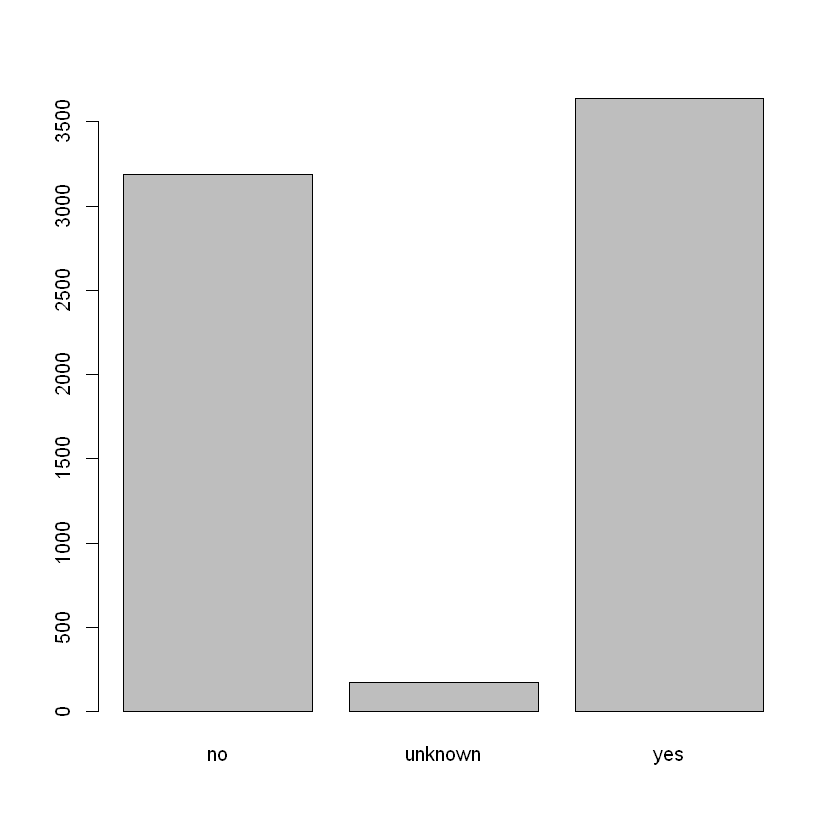

In [43]:
plot(trainSet$housing)

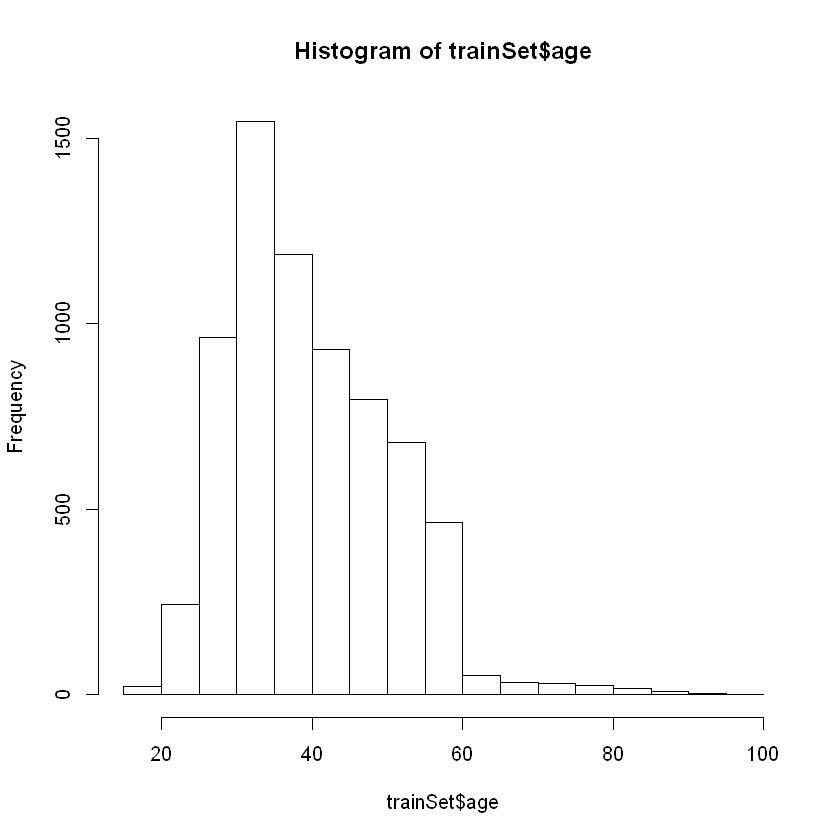

In [44]:
hist(trainSet$age)

In [45]:
# Fix the value of campaign as it includes last contact
trainSet[, 'campaign'] <- trainSet[, 'campaign'] - 1
predictSet[, 'campaign'] <- predictSet[, 'campaign'] - 1

# Quick check
min(trainSet[, 'campaign'])  # Previously = 1
min(predictSet[, 'campaign'])  # Previously = 1

[1] 0

[1] 0

In [46]:
set.seed(10)

train_idx <- caret::createDataPartition(y=trainSet[, 'subscribe'], p=.75, list=F)
train <- trainSet[train_idx, ]  # Train 75%
test <- trainSet[-train_idx, ] #Test 25%

In [47]:
# Checking the percentage distribution of target variable in each set
table(train$subscribe)/nrow(train)

table(test$subscribe)/nrow(test)


   0    1 
0.88 0.12 


        0         1 
0.8902857 0.1097143 

#### Feature engineering

In [48]:
#pdays : 99 previously not contacted customers

#On Train
train[, 'pdays_notcontacted'] <- as.integer(train$pdays == 999)
#On Test
test[, 'pdays_notcontacted'] <- as.integer(test$pdays == 999)

#On predictSet
predictSet[, 'pdays_notcontacted'] <- as.integer(predictSet$pdays == 999)

In [49]:
# Add new seasons variable to train and test (holdout)
# Train
train[, 'month_spring'] <- as.integer(train$month %in% c('mar','apr', 'may'))
train[, 'month_summer'] <- as.integer(train$month %in% c('jun','jul', 'aug'))
train[, 'month_autumn'] <- as.integer(train$month %in% c('sep','oct', 'nov'))
train[, 'month_winter'] <- as.integer(train$month %in% c('dec','jan', 'feb'))

# Test 
test[, 'month_spring'] <- as.integer(test$month %in% c('mar','apr', 'may'))
test[, 'month_summer'] <- as.integer(test$month %in% c('jun','jul', 'aug'))
test[, 'month_autumn'] <- as.integer(test$month %in% c('sep','oct', 'nov'))
test[, 'month_winter'] <- as.integer(test$month %in% c('dec','jan', 'feb'))


#PredictSet
predictSet[, 'month_spring'] <- as.integer(predictSet$month %in% c('mar','apr', 'may'))
predictSet[, 'month_summer'] <- as.integer(predictSet$month %in% c('jun','jul', 'aug'))
predictSet[, 'month_autumn'] <- as.integer(predictSet$month %in% c('sep','oct', 'nov'))
predictSet[, 'month_winter'] <- as.integer(predictSet$month %in% c('dec','jan', 'feb'))

In [50]:
# Add new variable to train and prediction set (holdout)
# On Train set
train[, 'age_ge_mean'] <- as.integer(train$age >= mean(train$age))

# On Train set
test[, 'age_ge_mean'] <- as.integer(test$age >= mean(test$age))


# On predictSet
predictSet[, 'age_ge_mean'] <- as.integer(predictSet$age >= mean(train$age))

In [51]:
#education 2 categories
#on trainset
train[, 'edu_ge_highschool'] <- as.integer(train$education %in% c('high.school ','university.degree', ' professional.course'))
train[, 'edu_le_basic'] <- as.integer(train$education %in% c('basic.9y ','basic.6y ', 'basic.4y ', 'unknown', 'illiterate'))

#on trainset
test[, 'edu_ge_highschool'] <- as.integer(test$education %in% c('high.school ','university.degree', ' professional.course'))
test[, 'edu_le_basic'] <- as.integer(test$education %in% c('basic.9y ','basic.6y ', 'basic.4y ', 'unknown', 'illiterate'))


#on predict set
predictSet[, 'edu_ge_highschool'] <- as.integer(predictSet$education %in% c('high.school ','university.degree', ' professional.course'))
predictSet[, 'edu_le_basic'] <- as.integer(predictSet$education %in% c('basic.9y ','basic.6y ', 'basic.4y ', 'unknown', 'illiterate'))



In [52]:
#psuccess
#On Train
train[, 'poutcome_success'] <- as.integer(train$pdays == 'success')

#On Test
test[, 'poutcome_success'] <- as.integer(test$pdays == 'success')

#On Test (predictSet)
predictSet[, 'poutcome_success'] <- as.integer(predictSet$pdays == 'success')

In [53]:
# On Train set
train[, 'cons.price.idx_ge_mean'] <- as.integer(train$cons.price.idx >= mean(train$cons.price.idx))

# On Train set
test[, 'cons.price.idx_ge_mean'] <- as.integer(test$cons.price.idx >= mean(test$cons.price.idx))


#On Test (predictSet)
predictSet[, 'cons.price.idx_ge_mean'] <- as.integer(predictSet$cons.price.idx >= mean(train$cons.price.idx))


In [54]:
# Add new variable on euribor to train and prediction set (holdout)
# On Train set
train[, 'euribor_ge_mean'] <- as.integer(train$euribor3m >= mean(train$euribor3m))

# On Test set
test[, 'euribor_ge_mean'] <- as.integer(test$euribor3m >= mean(test$euribor3m))


# On Test (predictSet)
predictSet[, 'euribor_ge_mean'] <- as.integer(predictSet$euribor3m >= mean(train$euribor3m))


In [55]:
# Add new variable on number employed if ge to the mean on the train and prediction set (holdout)
# On Train set
train[, 'nr.employed'] <- as.integer(train$nr.employed >= mean(train$nr.employed))
# On Test set
test[, 'nr.employed'] <- as.integer(test$nr.employed >= mean(test$nr.employed))


# On Test set
predictSet[, 'nr.employed'] <- as.integer(predictSet$nr.employed >= mean(train$nr.employed))


In [56]:
# Add new variable on campaign to train and prediction set (holdout)
# On Train set
train[, 'campaign_mostcommon'] <- as.integer(train$campaign == max(train$campaign))
train[, 'campaign_leastcommon'] <- as.integer(train$campaign == min(train$campaign))

# On Test set
test[, 'campaign_mostcommon'] <- as.integer(test$campaign == max(test$campaign))
test[, 'campaign_leastcommon'] <- as.integer(test$campaign == min(test$campaign))


# On Test (predictSet)
predictSet[, 'campaign_mostcommon'] <- as.integer(predictSet$campaign == max(train$campaign))
predictSet[, 'campaign_leastcommon'] <- as.integer(predictSet$campaign == min(train$campaign))


In [57]:
head(train)

,client_id,age,job,marital,education,default,housing,loan,contact,month,...,month_autumn,month_winter,age_ge_mean,edu_ge_highschool,edu_le_basic,poutcome_success,cons.price.idx_ge_mean,euribor_ge_mean,campaign_mostcommon,campaign_leastcommon
1,2,29,housemaid,single,high.school,no,no,no,telephone,may,...,0,0,0,0,0,0,1,1,0,0
2,3,39,unemployed,married,basic.9y,unknown,yes,no,telephone,jun,...,0,0,0,0,0,0,1,1,0,0
4,5,32,self-employed,single,university.degree,no,yes,no,cellular,may,...,0,0,0,1,0,0,0,0,0,0
5,6,29,admin.,single,high.school,unknown,yes,no,cellular,jul,...,0,0,0,0,0,0,1,1,0,0
6,7,51,self-employed,married,university.degree,unknown,yes,no,telephone,jun,...,0,0,1,1,0,0,1,1,0,1
8,9,52,services,married,high.school,no,yes,no,cellular,nov,...,1,0,1,0,0,0,0,1,0,1


In [58]:
#binning on job 
binning_cat <- woe.binning(train, 'subscribe', 'job')
binning_cat

,Group.2,Group.1,woe,iv.total.final,1,0,col.perc.a,col.perc.b,iv.bins
11,services + blue-collar,blue-collar,-42.843909,0.1435264,133,1497,0.2111111,0.3240260,0.0483771413
12,services + blue-collar,services,-42.843909,0.1435264,133,1497,0.2111111,0.3240260,0.0483771413
1,admin. + management + misc. level neg. + technician,admin.,-2.247286,0.1435264,348,2610,0.5523810,0.5649351,0.0002821268
2,admin. + management + misc. level neg. + technician,entrepreneur,-2.247286,0.1435264,348,2610,0.5523810,0.5649351,0.0002821268
3,admin. + management + misc. level neg. + technician,housemaid,-2.247286,0.1435264,348,2610,0.5523810,0.5649351,0.0002821268
4,admin. + management + misc. level neg. + technician,management,-2.247286,0.1435264,348,2610,0.5523810,0.5649351,0.0002821268
5,admin. + management + misc. level neg. + technician,technician,-2.247286,0.1435264,348,2610,0.5523810,0.5649351,0.0002821268
6,admin. + management + misc. level neg. + technician,unknown,-2.247286,0.1435264,348,2610,0.5523810,0.5649351,0.0002821268
7,misc. level pos.,retired,75.610063,0.1435264,149,513,0.2365079,0.1110390,0.0948671708
8,misc. level pos.,self-employed,75.610063,0.1435264,149,513,0.2365079,0.1110390,0.0948671708


In [59]:
# Apply the binning to the train data

tmp <- woe.binning.deploy(train, binning_cat, add.woe.or.dum.var='woe')
head(tmp[, c('job', 'job.binned', 'woe.job.binned')])

,job,job.binned,woe.job.binned
1,housemaid,admin. + management + misc. level neg. + technician,-2.247286
2,unemployed,misc. level pos.,75.610063
4,self-employed,misc. level pos.,75.610063
5,admin.,admin. + management + misc. level neg. + technician,-2.247286
6,self-employed,misc. level pos.,75.610063
8,services,services + blue-collar,-42.843909


In [60]:
# Binning on education
binning_ed <- woe.binning(trainSet, 'subscribe', 'education')
binning_ed

,Group.2,Group.1,woe,iv.total.final,1,0,col.perc.a,col.perc.b,iv.bins
4,basic.9y + basic.6y,basic.6y,-35.146021,0.04473058,116,1239,0.1411192,0.2005503,0.020887674
5,basic.9y + basic.6y,basic.9y,-35.146021,0.04473058,116,1239,0.1411192,0.2005503,0.020887674
1,basic.4y + professional.course + high.school,basic.4y,-6.869731,0.04473058,358,2882,0.4355231,0.4664940,0.002127617
2,basic.4y + professional.course + high.school,high.school,-6.869731,0.04473058,358,2882,0.4355231,0.4664940,0.002127617
3,basic.4y + professional.course + high.school,professional.course,-6.869731,0.04473058,358,2882,0.4355231,0.4664940,0.002127617
6,university.degree + misc. level pos.,illiterate,24.020807,0.04473058,348,2057,0.4233577,0.3329556,0.021715293
7,university.degree + misc. level pos.,university.degree,24.020807,0.04473058,348,2057,0.4233577,0.3329556,0.021715293
8,university.degree + misc. level pos.,unknown,24.020807,0.04473058,348,2057,0.4233577,0.3329556,0.021715293


In [61]:
# Apply the binning to the train data
tmp_ed <- woe.binning.deploy(train, binning_ed, add.woe.or.dum.var='woe')
head(tmp_ed[, c('education', 'education.binned', 'woe.education.binned')])


,education,education.binned,woe.education.binned
1,high.school,basic.4y + professional.course + high.school,-6.869731
2,basic.9y,basic.9y + basic.6y,-35.146021
4,university.degree,university.degree + misc. level pos.,24.020807
5,high.school,basic.4y + professional.course + high.school,-6.869731
6,university.degree,university.degree + misc. level pos.,24.020807
8,high.school,basic.4y + professional.course + high.school,-6.869731


In [62]:
# Get the IV and DV list name
# Dependent variable (DV)
dv_list <- c('subscribe')
# Independent variable (IV)
iv_list <- setdiff(colnames(train), dv_list)  # Exclude the target variable
iv_list <- setdiff(iv_list, 'client_id')  # Exclude the client_id

In [63]:
# Pick out categorical, boolean and numerical variable
iv_cat_list <- c()  # List to store categorical variable
iv_bool_list <- c()  # List to store boolean variable
iv_num_list <- c()  # List to store numerical variable
for (v in iv_list) {
    if (class(train[, v]) == 'factor') {  # Factor == categorical variable
        iv_cat_list <- c(iv_cat_list, v)
    } else if (class(train[, v]) == 'logical') {  # Logical == boolean variable
        iv_bool_list <- c(iv_bool_list, v)
    } else {  # Non-factor + Non-logical == numerical variable
        iv_num_list <- c(iv_num_list, v)
    }
}

In [64]:
# Loop through all categorical variables in train and test data sets
for (v in iv_cat_list) {
    
    # Remapping categorical variable on train data
    binning_cat <- woe.binning(train, 'subscribe', v)
    
    # Apply the binning to the train, valid and test data
    train <- woe.binning.deploy(train, binning_cat, add.woe.or.dum.var='woe')
    train <- woe.binning.deploy(train, binning_ed, add.woe.or.dum.var='woe')

    test <- woe.binning.deploy(test, binning_cat, add.woe.or.dum.var='woe')
    test <- woe.binning.deploy(test, binning_ed, add.woe.or.dum.var='woe')
    
    # Apply the binning to the test (holdout) data
    predictSet <- woe.binning.deploy(predictSet, binning_cat, add.woe.or.dum.var='woe')
    predictSet <- woe.binning.deploy(predictSet, binning_ed, add.woe.or.dum.var='woe')

}

In [65]:
head(train)

,client_id,age,job,marital,education,default,housing,loan,contact,month,...,education.binned,woe.education.binned,day_of_week.binned,woe.day_of_week.binned,education.binned.1,woe.education.binned.1,poutcome.binned,woe.poutcome.binned,education.binned.2,woe.education.binned.2
1,2,29,housemaid,single,high.school,no,no,no,telephone,may,...,basic.4y + professional.course + high.school,-6.869731,fri + mon,-15.58485,basic.4y + professional.course + high.school,-6.869731,nonexistent,-27.12918,basic.4y + professional.course + high.school,-6.869731
2,3,39,unemployed,married,basic.9y,unknown,yes,no,telephone,jun,...,basic.9y + basic.6y,-35.146021,fri + mon,-15.58485,basic.9y + basic.6y,-35.146021,nonexistent,-27.12918,basic.9y + basic.6y,-35.146021
4,5,32,self-employed,single,university.degree,no,yes,no,cellular,may,...,university.degree + misc. level pos.,24.020807,fri + mon,-15.58485,university.degree + misc. level pos.,24.020807,failure,35.48214,university.degree + misc. level pos.,24.020807
5,6,29,admin.,single,high.school,unknown,yes,no,cellular,jul,...,basic.4y + professional.course + high.school,-6.869731,fri + mon,-15.58485,basic.4y + professional.course + high.school,-6.869731,nonexistent,-27.12918,basic.4y + professional.course + high.school,-6.869731
6,7,51,self-employed,married,university.degree,unknown,yes,no,telephone,jun,...,university.degree + misc. level pos.,24.020807,tue,13.76316,university.degree + misc. level pos.,24.020807,nonexistent,-27.12918,university.degree + misc. level pos.,24.020807
8,9,52,services,married,high.school,no,yes,no,cellular,nov,...,basic.4y + professional.course + high.school,-6.869731,tue,13.76316,basic.4y + professional.course + high.school,-6.869731,nonexistent,-27.12918,basic.4y + professional.course + high.school,-6.869731


In [66]:
# Grouping the variable age onto 4 groups using WOE
binning_age <- woe.binning(train, 'subscribe', 'age')
binning_age

,woe,cutpoints.final,cutpoints.final[-1],iv.total.final,1,0,col.perc.a,col.perc.b,iv.bins
"(-Inf,26]",55.5550307,-Inf,26,0.1344239,53,223,0.08412698,0.04826840,1.992125e-02
"(26,36]",0.7635757,26,36,0.1344239,245,1783,0.38888889,0.38593074,2.258774e-05
"(36,55]",-31.5497773,36,55,0.1344239,224,2252,0.35555556,0.48744589,4.161111e-02
"(55, Inf]",78.2917180,55,Inf,0.1344239,108,362,0.17142857,0.07835498,7.286892e-02
Missing,NA,Inf,Missing,0.1344239,0,0,0.00000000,0.00000000,NA


In [67]:
# Apply the binning to the train data
tmp <- woe.binning.deploy(train, binning_age, add.woe.or.dum.var='woe')
head(tmp[, c('age', 'age.binned', 'woe.age.binned')])

,age,age.binned,woe.age.binned
1,29,"(26,36]",0.7635757
2,39,"(36,55]",-31.5497773
4,32,"(26,36]",0.7635757
5,29,"(26,36]",0.7635757
6,51,"(36,55]",-31.5497773
8,52,"(36,55]",-31.5497773


In [68]:
# Apply the new variable

# Loop through all numerical variables
for (v in iv_num_list) {
    
    # Discretizing numerical variable on train data
    binning_age <- woe.binning(train, 'subscribe', v)
    
    # Apply the binning to the train, valid and test data
    train <- woe.binning.deploy(train, binning_age, add.woe.or.dum.var='woe')
    test <- woe.binning.deploy(test, binning_age, add.woe.or.dum.var='woe')
    
    # Apply the binning to the predictSet data
    predictSet <- woe.binning.deploy(predictSet, binning_age, add.woe.or.dum.var='woe')
}

#### Converting categorical to dummy variables

In [69]:
#Step 1
# Get the IV and DV list name
# Dependent variable (DV)
dv_list <- c('subscribe')
# Independent variable (IV)
iv_list <- setdiff(colnames(train), dv_list)  # Exclude the target variable
iv_list <- setdiff(iv_list, 'client_id')  # Exclude the client_id

In [70]:
#Step 2
# Pick out categorical, boolean and numerical variable
iv_cat_list <- c()  # List to store categorical variable
iv_bool_list <- c()  # List to store boolean variable
iv_num_list <- c()  # List to store numerical variable
for (v in iv_list) {
    if (class(train[, v]) == 'factor') {  # Factor == categorical variable
        iv_cat_list <- c(iv_cat_list, v)
    } else if (class(train[, v]) == 'logical') {  # Logical == boolean variable
        iv_bool_list <- c(iv_bool_list, v)
    } else {  # Non-factor + Non-logical == numerical variable
        iv_num_list <- c(iv_num_list, v)
    }
}

In [71]:
#Step 3
#Create encoding
encoding <- build_encoding(dataSet=train, cols="job", verbose=F)

Warning message in checkAndReturnDataTable(dataSet):
"dataSet: has column names in double : you should take care of it. I changed them to be unique."

In [72]:
# Transform the categorical variable
tmp <- one_hot_encoder(dataSet=train, encoding=encoding, type='logical', drop=F, verbose=F)
setDF(tmp)
tmp <- tmp[, -ncol(tmp)]
head(tmp[, 84:ncol(tmp)])

Warning message in checkAndReturnDataTable(dataSet):
"dataSet: has column names in double : you should take care of it. I changed them to be unique."

woe.emp.var.rate.binned,cons.price.idx.binned,woe.cons.price.idx.binned,cons.conf.idx.binned,woe.cons.conf.idx.binned,euribor3m.binned,woe.euribor3m.binned,nr.employed.binned,woe.nr.employed.binned,pdays_notcontacted.binned,...,job.blue.collar,job.entrepreneur,job.housemaid,job.management,job.retired,job.self.employed,job.services,job.student,job.technician,job.unemployed
-96.03946,"(93.918,93.994]",-134.29207,"(-41.8,-36.4]",12.91121,"(4.153, Inf]",-90.579817,"(0, Inf]",-91.04475,"(-Inf,1]",...,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
-96.03946,"(93.994, Inf]",34.14925,"(-47.1,-41.8]",-64.16020,"(4.153, Inf]",-90.579817,"(0, Inf]",-91.04475,"(-Inf,1]",...,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE
43.99287,"(92.649,93.075]",35.70686,"(-47.1,-41.8]",-64.16020,"(1.262,4.153]",0.952655,"(-Inf,0]",91.33087,"(-Inf,1]",...,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE
-96.03946,"(93.075,93.918]",-42.38043,"(-47.1,-41.8]",-64.16020,"(4.153, Inf]",-90.579817,"(0, Inf]",-91.04475,"(-Inf,1]",...,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
-96.03946,"(93.994, Inf]",34.14925,"(-47.1,-41.8]",-64.16020,"(4.153, Inf]",-90.579817,"(0, Inf]",-91.04475,"(-Inf,1]",...,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE
43.99287,"(93.075,93.918]",-42.38043,"(-47.1,-41.8]",-64.16020,"(1.262,4.153]",0.952655,"(0, Inf]",-91.04475,"(-Inf,1]",...,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE


In [73]:
#Step 4
#Apply variable representation to all

# Loop through all categorical variables
for (v in iv_cat_list) {
    
    # Representing categorical variable on train data
    encoding <- build_encoding(dataSet=train, cols=v, verbose=F)
    
    # Apply the binning to the train, valid and test data
    train <- one_hot_encoder(dataSet=train, encoding=encoding, type='logical', drop=F, verbose=F)
    setDF(train)
    train <- train[, -ncol(train)]  # Drop the last dummy column
    
    
    test <- one_hot_encoder(dataSet=test, encoding=encoding, type='logical', drop=F, verbose=F)
    setDF(test)
    test <- test[, -ncol(test)]  # Drop the last dummy column
    
    # Apply the binning to the test (holdout) data
    predictSet <- one_hot_encoder(dataSet=predictSet, encoding=encoding, type='logical', drop=F, verbose=F)
    setDF(predictSet)
    predictSet <- predictSet[, -ncol(predictSet)]  # Drop the last dummy column
}

Warning message in checkAndReturnDataTable(dataSet):
"dataSet: has column names in double : you should take care of it. I changed them to be unique."Warning message in checkAndReturnDataTable(dataSet):
"dataSet: has column names in double : you should take care of it. I changed them to be unique."

In [74]:
#Represent categorical variables with incidence of target variable

# Find the incidence rates per category of a variable
tb <- table(train$job, train$subscribe)
incidence_map <- data.frame('v1'=rownames(tb), 'v2'=tb[, '1'] / (tb[, '0'] + tb[, '1']))
colnames(incidence_map) <- c('job', 'job_incidence')
incidence_map

,job,job_incidence
admin.,admin.,0.12828207
blue-collar,blue-collar,0.08027923
entrepreneur,entrepreneur,0.11578947
housemaid,housemaid,0.11278195
management,management,0.12561576
retired,retired,0.27192982
self-employed,self-employed,0.12021858
services,services,0.08471074
student,student,0.32456140
technician,technician,0.10116279


In [75]:
# Convert the categories with incidences
tmp <- plyr::join(x=train, y=incidence_map, by='job', type="left", match="all")  # Left join
head(tmp[, c('job', 'job_incidence')])

job,job_incidence
housemaid,0.11278195
unemployed,0.20437956
self-employed,0.12021858
admin.,0.12828207
self-employed,0.12021858
services,0.08471074


In [76]:
# Loop through all categorical variables
for (v in iv_cat_list) {
    
    # Find the incidence rates per category of a variable
    tb <- table(train[, v], train[, 'subscribe'])
    incidence_map <- data.frame('v1'=rownames(tb), 'v2'=tb[, '1'] / (tb[, '0'] + tb[, '1']))
    colnames(incidence_map) <- c(v, paste0(v, '_incidence'))  # Rename the columns to join
    
    # Apply the variable representation to the train, valid and test data
    train <- plyr::join(x=train, y=incidence_map, by=v, type="left", match="all")
    test <- plyr::join(x=test, y=incidence_map, by=v, type="left", match="all")
    
    # Apply the binning to the test (holdout) data
    predictSet <- plyr::join(x=predictSet, y=incidence_map, by=v, type="left", match="all")
}

In [77]:
#Standardize numerical variables

# Standardize the variable age on train and test (holdout)
# Train, valid, test
train[, 'age_scaled'] <- scale(train[, 'age'], center=T, scale=T)  # sd = 1, mean = 0
test[, 'age_scaled'] <- scale(test[, 'age'], center=T, scale=T)  # sd = 1, mean = 0
# Test (holdout)
predictSet[, 'age_scaled'] <- scale(predictSet[, 'age'], center=T, scale=T)  # sd = 1, mean = 0

In [78]:
Variable Correction and filtering prior to modelling

ERROR: Error in parse(text = x, srcfile = src): <text>:1:10: unexpected symbol
1: Variable Correction
             ^


In [ ]:
# Get the IV and DV list name
# Dependent variable (DV)
dv_list <- c('subscribe')
# Independent variable (IV)
iv_list <- setdiff(colnames(train), dv_list)  # Exclude the target variable
iv_list <- setdiff(iv_list, 'client_id')  # Exclude the client_id

In [ ]:
# Pick out categorical, boolean and numerical variable
iv_cat_list <- c()  # List to store categorical variable
iv_bool_list <- c()  # List to store boolean variable
iv_num_list <- c()  # List to store numerical variable
for (v in iv_list) {
    if (class(train[, v]) == 'factor') {  # Factor == categorical variable
        iv_cat_list <- c(iv_cat_list, v)
    } else if (class(train[, v]) == 'logical') {  # Logical == boolean variable
        iv_bool_list <- c(iv_bool_list, v)
    } else {  # Non-factor + Non-logical == numerical variable
        iv_num_list <- c(iv_num_list, v)
    }
}

In [ ]:
# Check infinite values
# Train,  test
sum(apply(sapply(train, is.infinite), 2, sum))
sum(apply(sapply(test, is.infinite), 2, sum))
# predictSet (holdout)
sum(apply(sapply(predictSet, is.infinite), 2, sum))

In [79]:
# Check missing value
# Train, valid, test
sum(apply(is.na(train), 2, sum))
sum(apply(is.na(test), 2, sum))
# Test (holdout)
sum(apply(is.na(predictSet), 2, sum))

[1] 0

[1] 0

[1] 0

#### Dropping categorical data and other conversions prior to modelling

In [90]:
#Categorical variables were already processed hence drop the available values
for (v in iv_cat_list) {
    # Train, valid, test
    train[, v] <- NULL
    test[, v] <- NULL
    
    # Test (holdout)
   predictSet[, v] <- NULL
}

In [91]:
# Convert boolean to int
for (v in iv_bool_list) {
    # Train, valid, test
    train[, v] <- as.integer(train[, v])
    test[, v] <- as.integer(test[, v])
    
    # Test (holdout)
    predictSet[, v] <- as.integer(predictSet[, v])
}

In [82]:
# Find the constant variable
var_list <- c()
for (v in c(iv_num_list, iv_bool_list)) {
    var_list <- c(var_list, var(train[, v], na.rm=T))
}
constant_var <- c(iv_num_list, iv_bool_list)[var_list == 0]
constant_var

[1] "poutcome_success"              "woe.pdays.binned"             
[3] "woe.pdays_notcontacted.binned" "woe.poutcome_success.binned"

In [83]:
# Drop the constant variables
for (v in constant_var) {
    # Train, valid, test
    train[, v] <- NULL
    test[, v] <- NULL
    
    # Test (holdout)
    predictSet[, v] <- NULL
}

#### Feature Selection using Fisher Score

In [92]:
FisherScore <- function(basetable, depvar, IV_list) {
  "
  This function calculate the Fisher score of a variable.
  
  Ref:
  ---
  Verbeke, W., Dejaeger, K., Martens, D., Hur, J., & Baesens, B. (2012). New insights into churn prediction in the telecommunication sector: A profit driven data mining approach. European Journal of Operational Research, 218(1), 211-229.
  "
  
  # Get the unique values of dependent variable
  DV <- unique(basetable[, depvar])
  
  IV_FisherScore <- c()
  
  for (v in IV_list) {
    fs <- abs((mean(basetable[which(basetable[, depvar]==DV[1]), v]) - mean(basetable[which(basetable[, depvar]==DV[2]), v]))) /
      sqrt((var(basetable[which(basetable[, depvar]==DV[1]), v]) + var(basetable[which(basetable[, depvar]==DV[2]), v])))
    IV_FisherScore <- c(IV_FisherScore, fs)
  }
  
  return(data.frame(IV=IV_list, fisher_score=IV_FisherScore))
}

varSelectionFisher <- function(basetable, depvar, IV_list, num_select=20) {
  "
  This function will calculate the Fisher score for all IVs and select the best
  top IVs.

  Assumption: all variables of input dataset are converted into numeric type.
  "
  
  fs <- FisherScore(basetable, depvar, IV_list)  # Calculate Fisher Score for all IVs
  num_select <- min(num_select, ncol(basetable))  # Top N IVs to be selected
  return(as.vector(fs[order(fs$fisher_score, decreasing=T), ][1:num_select, 'IV']))
}

In [93]:
# Calculate Fisher Score for all variable
# Get the IV and DV list
dv_list <- c('subscribe')  # DV list
iv_list <- setdiff(names(train), dv_list)  # IV list excluded DV
iv_list <- setdiff(iv_list, 'client_id')  # Excluded the client_id
fs <- FisherScore(train, dv_list, iv_list)
head(fs)

Warning message in mean.default(basetable[which(basetable[, depvar] == DV[1]), v]):
"argument is not numeric or logical: returning NA"Warning message in mean.default(basetable[which(basetable[, depvar] == DV[2]), v]):
"argument is not numeric or logical: returning NA"

ERROR: Error in var(basetable[which(basetable[, depvar] == DV[1]), v]): Calling var(x) on a factor x is defunct.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.


In [86]:
# Select top 30 variables according to the Fisher Score
best_fs_var <- varSelectionFisher(train, dv_list, iv_list, num_select=30)
head(best_fs_var,30)

Warning message in mean.default(basetable[which(basetable[, depvar] == DV[1]), v]):
"argument is not numeric or logical: returning NA"Warning message in mean.default(basetable[which(basetable[, depvar] == DV[2]), v]):
"argument is not numeric or logical: returning NA"

ERROR: Error in var(basetable[which(basetable[, depvar] == DV[1]), v]): Calling var(x) on a factor x is defunct.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.


In [94]:
# Apply variable selection to the data
# Train
var_select <- names(train)[names(train) %in% best_fs_var]
train_processed <- train[, c('client_id', var_select, 'subscribe')]

# Test
var_select <- names(test)[names(test) %in% best_fs_var]
test_processed <- test[, c('client_id', var_select, 'subscribe')]
# Test (holdout)
var_select <- names(predictSet)[names(predictSet) %in% best_fs_var]
test_holdout_processed <- predictSet[, c('client_id', var_select)]

ERROR: Error in names(train) %in% best_fs_var: object 'best_fs_var' not found


In [95]:
# Check if train and test (holdout) have same variables
# Train,test
dim(train_processed)
dim(test_processed)

# Test (holdout)
dim(test_holdout_processed)

ERROR: Error in eval(expr, envir, enclos): object 'train_processed' not found


In [96]:
# Rename the data columns
for (v in colnames(train_processed)) {
    
    # Fix the column name
    fix_name <- str_replace_all(v, "[^[:alnum:] ]", "_")
    fix_name <- gsub(' +', '', fix_name) 
    
    # Train, valid, test
    colnames(train_processed)[colnames(train_processed) == v] <- fix_name
    colnames(test_processed)[colnames(test_processed) == v] <- fix_name
    
    # Test (holdout)
    colnames(test_holdout_processed)[colnames(test_holdout_processed) == v] <- fix_name
}

ERROR: Error in colnames(train_processed): object 'train_processed' not found


In [97]:
# Print out to check
head(train_processed)

ERROR: Error in head(train_processed): object 'train_processed' not found


## 4. Gradient Boosted Trees

In [ ]:
#load GBM
getParamSet("classif.gbm")

#set 10 fold cross validation
rdesc <- makeResampleDesc("CV",iters = 5)

# Define model - make a learner
learner <- makeLearner("classif.gbm", predict.type="prob", fix.factors.prediction=T)

# Define the task
train_task <- makeClassifTask(id="bank_train", data=train_processed[, -1], target="subscribe")


# Set hyper parameter tuning
tune_params <-makeParamSet(
makeDiscreteParam("distribution", values = "bernoulli"),
makeIntegerParam("n.trees", lower = 100, upper = 1000), #number of trees
makeIntegerParam("interaction.depth", lower = 2, upper = 10), #depth of tree
makeNumericParam("shrinkage",lower = 0.01, upper = 1)
)
ctrl = makeTuneControlGrid()

# Run the hyper parameter tuning with k-fold CV
if (length(tune_params$pars) > 0) {
    # Run parameter tuning
    res <- tuneParams(learner, task=train_task, resampling=rdesc,
      par.set=tune_params, control=ctrl, measures=list(mlr::auc))
    
    # Extract best model
    best_learner <- res$learner
    
} else {
    # Simple cross-validation
    res <- resample(learner, train_task, rdesc, measures=list(mlr::auc))
    
    # No parameter for tuning, only 1 best learner
    best_learner <- learner
}

In [ ]:
#check best parameter
res$x

In [ ]:
# Retrain the model with tbe best hyper-parameters
best_md <- mlr::train(best_learner, train_task)

getLearnerModel(best_md)

In [ ]:
#Accuracy of train data
predt <- predict(best_md, newdata=train_processed[, -1])
mlr::performance(predt, list(mlr::auc,acc,f1))

In [ ]:
#Make prediction on test data
pred <- predict(best_md, newdata=test_processed[, -1])
#Accuracy
mlr::performance(pred, list(mlr::auc,acc,f1))

In [ ]:
# Make prediction on test (holdout) data
pred <- predict(best_md, newdata=test_holdout_processed[, -1])
pred